In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
%matplotlib inline

## Triangulation
Nikil Pancha

In [13]:
points = np.mgrid[-0.5:1:0.5, -0.5:1:0.5, -0.5:1:0.5].reshape(3, -1).T
colors = plt.cm.viridis(np.arange(len(points))/len(points))

In [63]:
cam1 = {
    'position': np.array([3, -3, 2]),
    'target': np.array([0, 0, 0]),
    'up': np.array([0, 0, 1]),
    'focal_length': 0.0600,
    'film_width': 0.0350,
    'film_height': 0.0350,
    'width': 256,
    'height': 256,
}

cam2 = {
    'position': np.array([2, 3, 3]),
    'target': np.array([0, 0, 0]),
    'up': np.array([0, 0, 1]),
    'focal_length': 0.0600,
    'film_width': 0.0350,
    'film_height': 0.0350,
    'width': 256,
    'height': 256,
}
cam3 = {
    'position': np.array([-1, -4, 6]),
    'target': np.array([0, 0, 0]),
    'up': np.array([0, 0, 1]),
    'focal_length': 0.0600,
    'film_width': 0.0350,
    'film_height': 0.0350,
    'width': 256,
    'height': 256,
}
def randcam(r=5):
    alpha = np.random.rand()*2*np.pi
    beta = np.random.rand()*2*np.pi
    pos = np.array([r * np.cos(beta) * np.cos(alpha) ,  r* np.cos(beta) * np.sin(alpha), r * np.sin(beta)])
#     pos=np.random.gamma(7.5, 1, 3)
    return {
        'position': pos,
        'target': np.array([0, 0, 0]),
        'up': np.array([0, 0, 1]),
        'focal_length': 0.0600,
        'film_width': 0.0350,
        'film_height': 0.0350,
        'width': 256,
        'height': 256,
    }

In [44]:
def camera_coordinate_system(cam):
    zcam = np.array(cam['target']) - np.array(cam['position']);
    xcam = np.cross(zcam, cam['up']);

    ycam = np.cross(zcam, xcam);
    zcam = zcam / np.linalg.norm(zcam);
    xcam = xcam / np.linalg.norm(xcam);
    ycam = ycam / np.linalg.norm(ycam);
    origin = cam['position'];
    return [xcam, ycam, zcam, origin]

In [45]:
def extrinsic_matrix(cam):
    xcam, ycam, zcam, origin = camera_coordinate_system(cam)
    R = np.vstack((xcam, ycam, zcam)).T
    M = np.vstack((R, -origin @ R))
    return M
def intrinsic_matrix(cam):
    cx = (cam['width']+1) * 0.5;
    cy = (cam['height']+1) * 0.5;

    fx = cam['focal_length'] * cam['width'] / cam['film_width'];
    fy = cam['focal_length'] * cam['height'] / cam['film_height'];
    K = np.array([[fx, 0, 0], [0, fy, 0], [cx, cy, 1]])
    return K
def camera_matrix(cam):
    return extrinsic_matrix(cam) @ intrinsic_matrix(cam)
def world_to_xy(cam, points):
    P = camera_matrix(cam)
    points = np.hstack((points, np.ones((len(points), 1)))) @ P
    x = points[:, 0] / points[:, 2]
    y = points[:, 1] / points[:, 2]
    return np.vstack((x,y)).T

Triangulation is the process of determining the location of poitns in 3d space given projections into 2d planes. With only a single image, this is impossible to determine, but if we are given examples from two camera matrices $B$, $C$, then we know that if the true position of the point is $X$, and the given points are $x=(u\;v\;1)^T$ and $y=(u'\;v'\;1)^T$, we want $k_1 x = BX$ and $k_2 x = CX$.

Let 
$$
D = \begin{pmatrix}
u B_3^T - B_1^T\\
v B_3^T - B_2^T\\
u' C_3^T - C_1^T\\
v' C_3^T - C_2^T\\
\end{pmatrix}
$$
We can then solve the system $DX = 0$ for $X$ (in the least squares sense), which corresponds to finding the minimum eigenvector of $X$.

Let us examine the first row to see how this works. We want $u B_3^T - B_1^T = 0$, or, equivalently, $u B_3^T = B_1^T$. Observe that ideally, $k_1=k_2=Z$, to undo the last step of the projection into image coordinates. This cannot be done directly, however, because we do not know $Z$. We can, however, say that in the solution, we will have that $Z = B_3^T X$ and $Z = C_3^T X$. We can see that $u B_3^T X = B_1^T X$ then becomes $uZ = B_1^T X$, which is the exact expression in the forward projection. 

In [46]:
def triangulate(*pointss, cameras):
    n = len(pointss[0])
    points3d = np.zeros((n, 3))
    for i, points in enumerate(zip(*pointss)):
        points3d[i] = triangulate_one(*points, cameras=tuple(i.T for i in cameras));
    return points3d
def triangulate_one(*points, cameras):
    A = np.zeros((2*len(points), 4))
    for i, (pt, c) in enumerate(zip(points, cameras)):
        A[2*i:2*(i+1)] = np.outer(pt, c[2]) - c[:2];
    *_, vt = np.linalg.svd(A);
    X = vt[-1]
    X = X/X[-1]
    return X[:3]

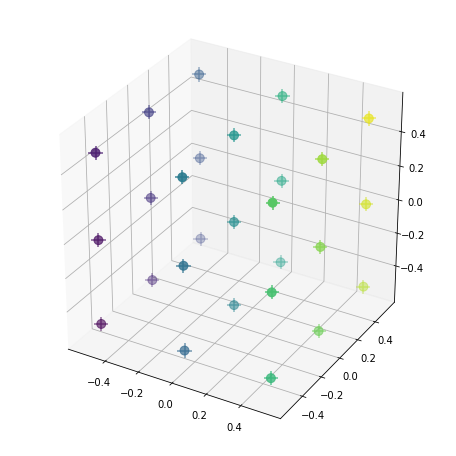

In [47]:
P1 = camera_matrix(cam1)
P2 = camera_matrix(cam2)
px1 = world_to_xy(cam1, points)
px2 = world_to_xy(cam2, points)
rec = triangulate(px1, px2, cameras=(P1, P2))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(*points.T, c=colors, s=80)
ax.scatter(*rec.T, c=colors, marker='+', s=200)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(-0.6, 0.6);

Triangulation: RMSE=0.08995


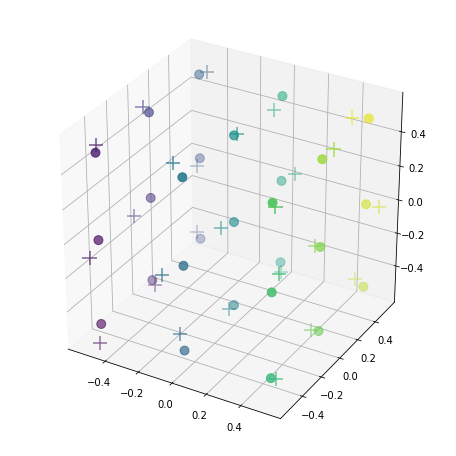

In [48]:
np.random.seed(12310192)
sigma = 5
P1 = camera_matrix(cam1)
P2 = camera_matrix(cam2)
px1 = world_to_xy(cam1, points)
px2 = world_to_xy(cam2, points)
px1 += sigma * np.random.randn(*px1.shape)
px2 += sigma * np.random.randn(*px2.shape)
rec = triangulate(px1, px2, cameras=(P1, P2))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(*points.T, c=colors, s=80)
ax.scatter(*rec.T, c=colors, marker='+', s=200)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(-0.6, 0.6);
print('Triangulation: RMSE=%.5f'%(np.sqrt((((rec-points)**2).sum(1)).mean(0))))

#### Adding a third camera
If we add a third camera, we would expect the triangulation error to decrease, and we do indeed see that.

Triangulation: RMSE=0.07791


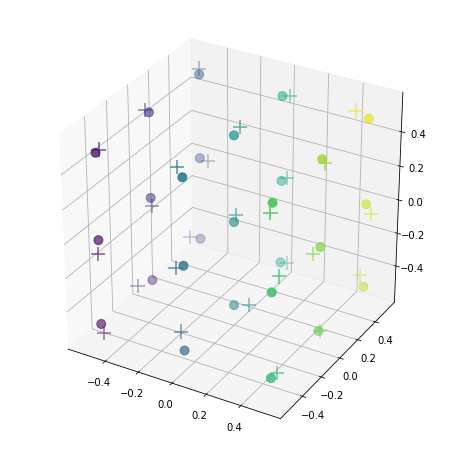

In [49]:
np.random.seed(12310192)
sigma = 5
P1 = camera_matrix(cam1)
P2 = camera_matrix(cam2)
P3 = camera_matrix(cam3)
px1 = world_to_xy(cam1, points)
px2 = world_to_xy(cam2, points)
px3 = world_to_xy(cam3, points)
px1 += sigma * np.random.randn(*px1.shape)
px2 += sigma * np.random.randn(*px2.shape)
px3 += sigma * np.random.randn(*px3.shape)
rec = triangulate(px1, px2, px3, cameras=(P1, P2, P3))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(*points.T, c=colors, s=80)
ax.scatter(*rec.T, c=colors, marker='+', s=200)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(-0.6, 0.6);
print('Triangulation: RMSE=%.5f'%(np.sqrt((((rec-points)**2).sum(1)).mean(0))))

#### N cameras
We can also try to do this with $n$ cameras, and see how the reconstruction error is as a function of number of cameras. Interestingly, although we see definite improvement in triangulation accuracy, the error does not converge to zero as the number of cameras increases. This is likely due to the minimum eigenvector procedure, which, in the presence of noise, will not necessarily have an averaging effect.

In [81]:
def n_camera_error(n, sigma=10, seed=148192123):
    np.random.seed(seed)
    cams = [randcam() for _ in range(n)]
    camera_matrices = list(map(camera_matrix, cams))
    ps = [world_to_xy(c, points) + sigma * np.random.randn(len(points), 2) for c in cams]
    rec = triangulate(*ps, cameras=camera_matrices)
    return np.sqrt((((rec-points)**2).sum(1)).mean(0)), rec

In [82]:
errs = []
for i in range(2, 50):
    err, rec = n_camera_error(i)
    errs.append(err)

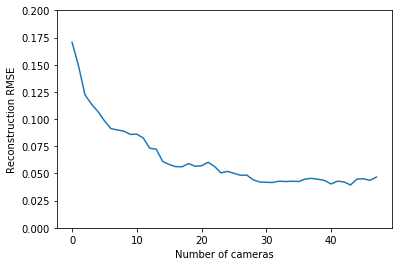

In [86]:
plt.plot(errs)
plt.ylim(0, 0.2);
plt.xlabel('Number of cameras')
plt.ylabel('Reconstruction RMSE');

Triangulation (averaged over 50 cameras): RMSE=0.02046


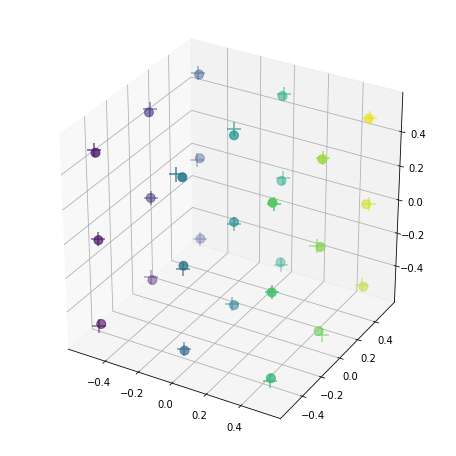

In [80]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(*points.T, c=colors, s=80)
ax.scatter(*rec.T, c=colors, marker='+', s=200)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(-0.6, 0.6);
print('Triangulation (averaged over 50 cameras): RMSE=%.5f'%(np.sqrt((((rec-points)**2).sum(1)).mean(0))))

#### Other triangulation methods
One other method in triangulation is to make a correction to the points before computing the triangulation. I have implemented the Sampson approximation, which uses a first order approximation to the error. This type of method works well in low-noise scenarios, but not as well when there is a lot of noise

In [50]:
def get_fundamental_matrix(p1s, p2s):
    if p1s.shape[1] != 3:
        p1s = np.append(p1s, np.ones((len(p1s),1)), axis=1)
    if p2s.shape[1] != 3:
        p2s = np.append(p2s, np.ones((len(p1s),1)), axis=1)
    W = np.array([np.outer(i,j).reshape(-1) for i,j in zip(p2s, p1s)])
    *_,vt = np.linalg.svd(W)
    F = vt[-1].reshape(3,3)
    u,s,vt = np.linalg.svd(F)
    s[2:] = 0
    return ((u*s) @ vt)
def sampson(p1, p2, F=None):
    if F is None:
        F = get_fundamental_matrix(p1, p2)
    pps = []
    for x, xp in zip(p1, p2):
        pps.append(sampson_one(x, xp, F))
    pps = np.array(pps)
    return pps[:, :2], pps[:, 2:]
def sampson_one(x, xp, F):
    bx = np.append(x, xp)
    x = np.append(x, 1)
    xp = np.append(xp, 1)
    J = np.array((F[:, 0] @ xp, F[:, 1] @ xp, F[:, 0] @ x, F[:, 1] @ x))
    update = - xp @ F @ x / (np.sum(J**2)) * J
    return bx + update

Simple triangulation: RMSE=0.18096
Sampson correction: RMSE=0.17485


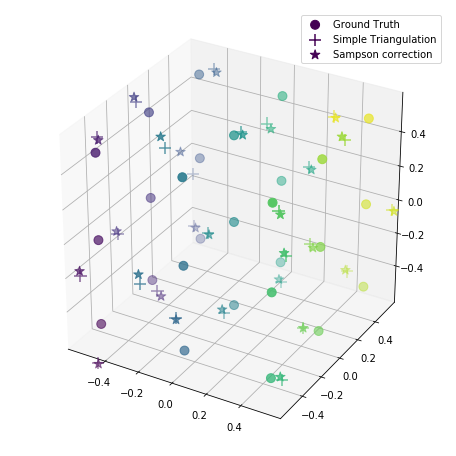

In [53]:
np.random.seed(12310192)
sigma = 10
P1 = camera_matrix(cam1)
P2 = camera_matrix(cam2)
px1 = world_to_xy(cam1, points)
px2 = world_to_xy(cam2, points)
F = get_fundamental_matrix(px1, px2)
px1 += sigma * np.random.randn(*px1.shape)
px2 += sigma * np.random.randn(*px2.shape)
# px1, px2 = sampson(px1, px2, F)
rec = triangulate(px1, px2, cameras=(P1, P2))
rec2 = triangulate(*sampson(px1, px2, F), cameras=(P1, P2, P3))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(*points.T, c=colors, s=80, label='Ground Truth')
ax.scatter(*rec.T, c=colors, marker='+', s=150, label='Simple Triangulation')
ax.scatter(*rec2.T, c=colors, marker='*', s=100, label='Sampson correction')
ax.legend(loc='best')
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(-0.6, 0.6);
print('Simple triangulation: RMSE=%.5f'%(np.sqrt((((rec-points)**2).sum(1)).mean(0))))
print('Sampson correction: RMSE=%.5f'%(np.sqrt((((rec2-points)**2).sum(1)).mean(0))))